### RFM 분석
####  사용자별로 얼마나 최근에, 얼마나 자주, 얼마나 많은 금액을 지출했는지에 따라 사용자들의 분포를 확인할 수 있고, 사용자 그룹(또는 등급)을 나누어 분류하는 분석 기법이다. 구매 가능성이 높은 고객을 선정할 때 용이한 데이터 분석 방법이며, 사용자들의 평소 구매 패턴을 기준으로 분류를 진행하기 때문에 각 사용자 그룹의 특성에 따라 차별화된 마케팅 메세지를 전달할 수 있다.

- Recency : 얼마나 최근에 구매했는가
- Frequency : 얼마나 자주 구매했는가
- Monetary : 얼마나 많은 금액을 지출했는가


### 고객 분석
​
> CustomerID : 고객번호  
PurchaseDate : 구매 날짜  
TransactionAmount : 결제 금액  
ProductInformation : 상품 정보  
OrderID : 주문 번호  
Location : 주문 지역  


,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris
...,...,...,...,...,...,...
995,2970,2023-06-10,759.62,Product B,275284,London
996,6669,2023-06-10,941.50,Product C,987025,New York
997,8836,2023-06-10,545.36,Product C,512842,London
998,1440,2023-06-10,729.94,Product B,559753,Paris


0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1258: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


<Axes: xlabel='CustomerID', ylabel='TransactionAmount'>

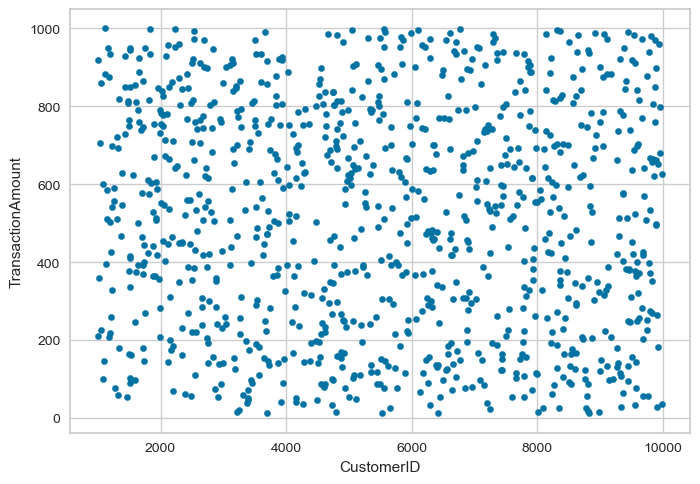

In [93]:
from datetime import datetime
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

customer_order_df = pd.read_csv('./datasets/customer_order_data.csv')

display(customer_order_df)

display(customer_order_df.duplicated().sum())

customer_order_df.info()

customer_order_df.plot(x="CustomerID",y="TransactionAmount",kind="scatter")






In [94]:
#recency구하기
recency = (pd.to_datetime(datetime.now().date(),dayfirst=True) - pd.to_datetime(customer_order_df["PurchaseDate"]))
customer_order_df["Recency"] = recency.astype("int64") //1000000000 // 60 // 60 //24
customer_order_df

customer_rfm = customer_order_df.groupby("CustomerID")["Recency"].min().reset_index().drop("CustomerID",axis=1)
customer_rfm

,Recency
0,149
1,137
2,116
3,159
4,129
...,...
941,158
942,154
943,128
944,173


In [95]:
#frequency 구하기
frequency = customer_order_df[["CustomerID"]].value_counts()
display(frequency)

frequency = frequency.reset_index().sort_values(by="CustomerID").reset_index(drop=True)

customer_rfm["frequency"] = frequency["count"]
customer_rfm

CustomerID
5557          3
7363          3
4804          3
1011          2
2133          2
             ..
4166          1
4178          1
4185          1
4190          1
9991          1
Name: count, Length: 946, dtype: int64

,Recency,frequency
0,149,2
1,137,1
2,116,1
3,159,1
4,129,1
...,...,...
941,158,1
942,154,1
943,128,1
944,173,1


In [96]:
#Mondetary 구하기
monetary = customer_order_df.groupby("CustomerID")["TransactionAmount"].sum()
customer_rfm["monetary"] = monetary.reset_index()["TransactionAmount"]
customer_rfm

,Recency,frequency,monetary
0,149,2,1129.02
1,137,1,359.29
2,116,1,704.99
3,159,1,859.82
4,129,1,225.72
...,...,...,...
941,158,1,960.53
942,154,1,679.11
943,128,1,798.01
944,173,1,36.10


In [97]:
#정규화
# customer_rfm.drop("CustomerID",axis=1,inplace=True)
from sklearn.preprocessing import MinMaxScaler

normalization = MinMaxScaler()
rfm_normalization = normalization.fit_transform(customer_rfm)
rfm_normalization = pd.DataFrame(rfm_normalization, columns=customer_rfm.columns)
display(rfm_normalization)




,Recency,frequency,monetary
0,0.550000,0.5,0.471795
1,0.350000,0.0,0.146647
2,0.000000,0.0,0.292677
3,0.716667,0.0,0.358080
4,0.216667,0.0,0.090224
...,...,...,...
941,0.700000,0.0,0.400622
942,0.633333,0.0,0.281745
943,0.200000,0.0,0.331970
944,0.950000,0.0,0.010125


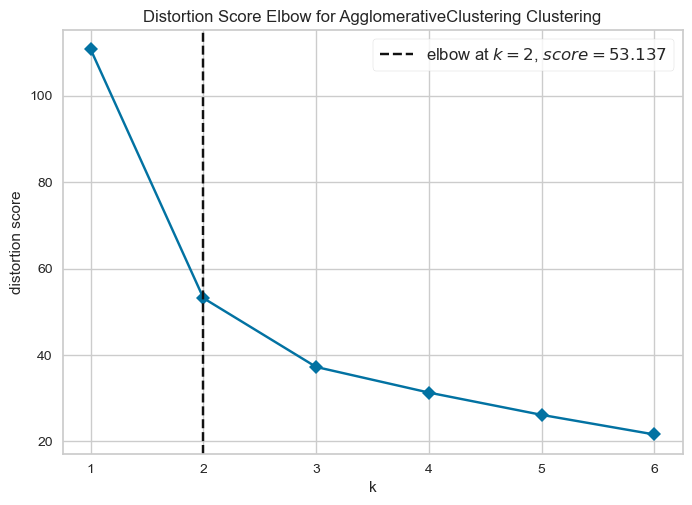

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [115]:
#데이터 클러스터링 
model = AgglomerativeClustering()

# k_elbow_visualizer = KElbowVisualizer(model, k=(3, 9), timings=True)
k_elbow_visualizer = KElbowVisualizer(model, k=(1, 7), timings=False)
k_elbow_visualizer.fit(rfm_normalization)

k_elbow_visualizer.show()

# agglomerative_clustering = AgglomerativeClustering(n_clusters=5).fit(rfm_normalization)
# customer_rfm.loc[:, 'cluster'] = agglomerative_clustering.labels_
# customer_rfm.loc[:, 'cluster'].value_counts()
# customer_rfm

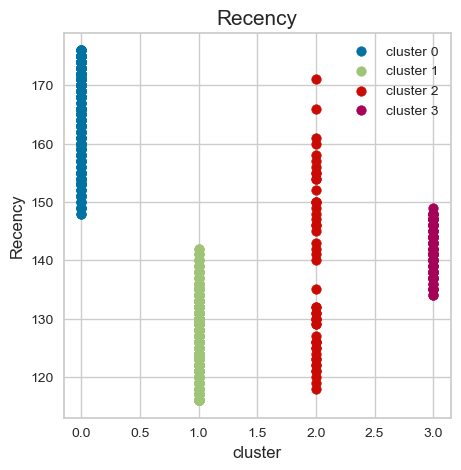

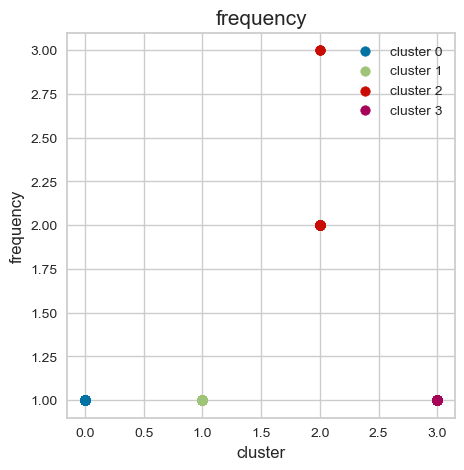

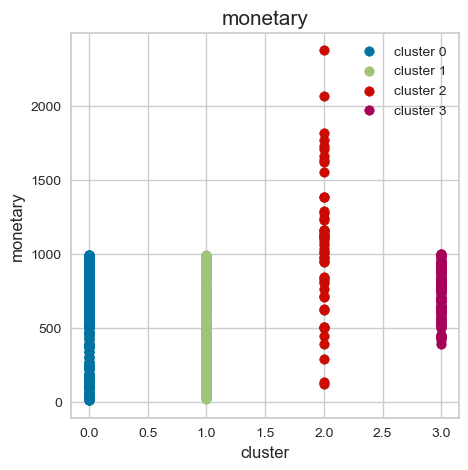

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recency : 얼마나 최근에 구매했는가
# Frequency : 얼마나 자주 구매했는가
# Monetary : 얼마나 많은 금액을 지출했는가
titles = ['Recency', 'frequency', 'monetary']

# 클러스터(집단) 개수
k = 5

# 각 항목별
for title in titles:
    plt.figure(figsize=(5, 5))
    
    # 집단 별
    for i in range(k):
#     scatter: 산점도(분포도)
        plt.scatter(customer_rfm.loc[customer_rfm['cluster'] == i, 'cluster'], 
                   customer_rfm.loc[customer_rfm['cluster'] == i, title], 
                    label=f'cluster {i}')

#     색상별 제목(label) 표시
    plt.legend()
    plt.title(title, size=15)
    plt.xlabel('cluster', size=12)
    plt.ylabel(title, size=12)
    plt.show()   

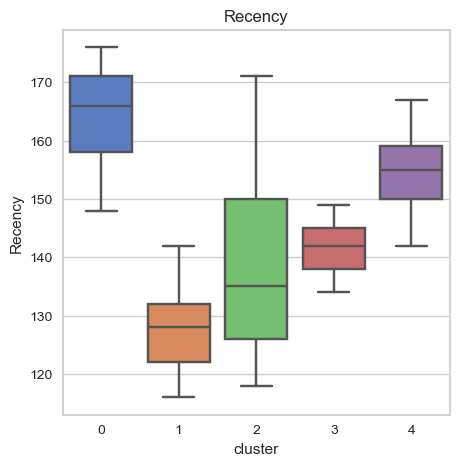

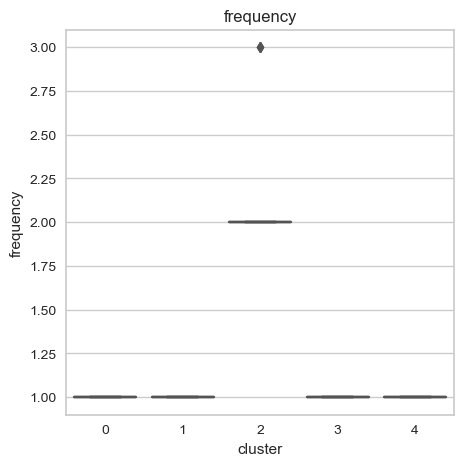

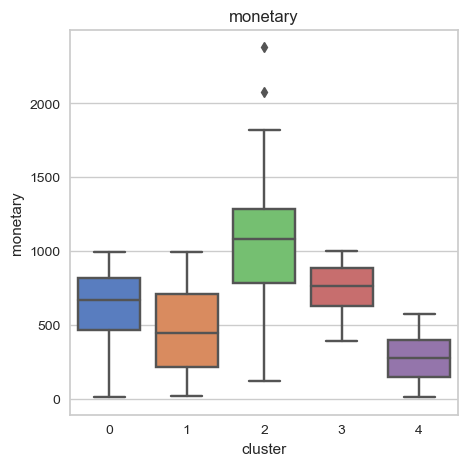

In [100]:

for title in titles:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=customer_rfm.cluster, y=customer_rfm[title], palette='muted')
    plt.title(title)
    plt.show()

R, F, M 점수는 1~4로 계산함.
Cluster0과 1은 동점이기 때문에 최근 구매(R)의 중요 여부에 따라 고객 등급을 매길 수 있다.
여기서는 최근 구매를 더 중요하다고 가정한다.  
Cluster0: Bronze, (1, 1, 2) = 4  
Cluster1: VIP, (5, 1, 4) = 10  
Cluster2: VVIP, (3, 5, 3) = 11  
Cluster3: Gold (2, 1, 5) = 8  
Cluster4: Silver (4, 1, 1) = 6  

In [101]:
customer_rfm['cluster'] = customer_rfm['cluster'].replace([0, 1, 2, 3, 4], ['Bronze', 'VIP', 'VVIP', 'GOLD','Silver'])
customer_rfm

,Recency,frequency,monetary,cluster
0,149,2,1129.02,VVIP
1,137,1,359.29,VIP
2,116,1,704.99,VIP
3,159,1,859.82,Bronze
4,129,1,225.72,VIP
...,...,...,...,...
941,158,1,960.53,Bronze
942,154,1,679.11,Bronze
943,128,1,798.01,VIP
944,173,1,36.10,Bronze


<Axes: xlabel='cluster', ylabel='count'>

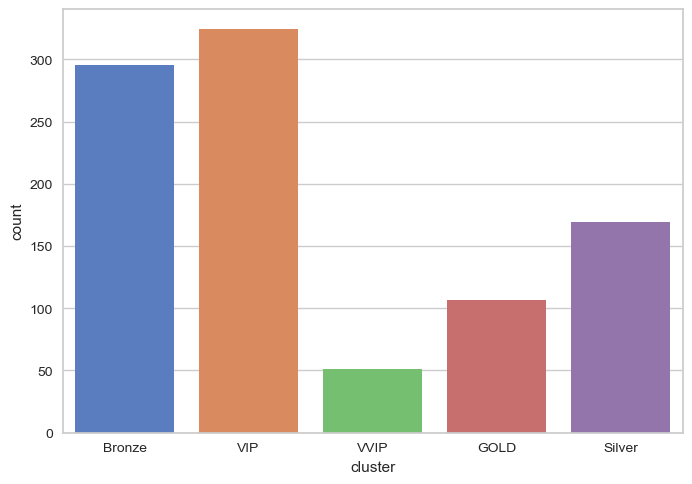

In [102]:
customer_rfm['cluster'].value_counts()
order = ['Bronze', 'VIP', 'VVIP', 'GOLD','Silver']
sns.countplot(x='cluster', data=customer_rfm, palette='muted', order=order)